<a href="https://colab.research.google.com/github/shendongqiang/test/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
cd '/content/gdrive/MyDrive/MPS/ResNet/'

/content/gdrive/MyDrive/MPS/ResNet


In [32]:
pwd

'/content/gdrive/MyDrive/MPS/ResNet'

In [33]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [34]:
from torchvision import datasets, transforms
data_path = '../data/CIFAR10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [35]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [36]:
label_map_2 = {0: 0, 2: 1}
class_names_2 = ['airplane', 'bird']
cifar2 = [(img, label_map_2[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map_2[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [75]:
img, _ = cifar2[0]
img.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

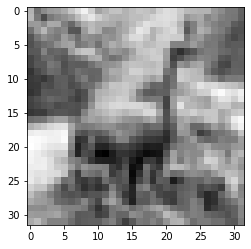

In [76]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

In [42]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [43]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [44]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [45]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [46]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [49]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2021-08-17 01:08:32.743339 Epoch 1, Training loss 2.38970518795548
2021-08-17 01:09:54.324306 Epoch 10, Training loss 0.3986331187425905
2021-08-17 01:11:24.830889 Epoch 20, Training loss 0.32960435045752556
2021-08-17 01:12:55.373762 Epoch 30, Training loss 0.2768047801248587
2021-08-17 01:14:25.787947 Epoch 40, Training loss 0.24397482428770917
2021-08-17 01:15:56.107761 Epoch 50, Training loss 0.2082107793183843
2021-08-17 01:17:26.586909 Epoch 60, Training loss 0.17616114831843954
2021-08-17 01:18:56.988926 Epoch 70, Training loss 0.15039582021392076
2021-08-17 01:20:27.384128 Epoch 80, Training loss 0.13086794690484074
2021-08-17 01:21:57.798007 Epoch 90, Training loss 0.11031112926685886
2021-08-17 01:23:28.122849 Epoch 100, Training loss 0.09905446556865409
Accuracy train: 0.95
Accuracy val: 0.87


In [50]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(75810, [864, 32, 9216, 32, 32, 65536, 32, 64, 2])

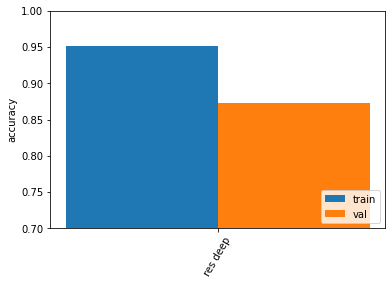

In [51]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()


In [54]:
pwd

'/content/gdrive/My Drive/MPS/ResNet'

In [55]:
trainedModel_path = '../trainedModel/ResNet/'
torch.save(model.state_dict(), trainedModel_path + 'cifar2.pt')

In [60]:
#loaded_model = NetResDeep()  # <1>
#loaded_model.load_state_dict(torch.load(trainedModel_path+'cifar2.pt'))